In [96]:
import plotly.graph_objs as go
import numpy as np
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

# Delta-Hedging Uniswap V3 Position


В этой статье я покажу как можно хеджировать Impermanent Loss на Uniswap V3.

#### Содержание статьи
1. Профиль юнисвоп позиции
2. Что такое дельта юнисвоп позции
3. Хеджируем дельту
4. 

### Профиль Uniswap V3 позиции

В одной из прошлых статей, где я подробно рассказывал про Impermanent loss, мы построили профиль позиции провайдера ликвидности:

In [62]:
def get_liquidity_from_token0(x0, p0, pb):
    """
        This function returns liquidity from token0 amount
    """
    return x0 / (1 / (p0)**0.5 - 1 / (pb)**0.5)

def get_token1_amount_from_upper_price(L, pa, pb):
    """
        This function returns the amount of token1 when price crosses upper price
    """
    return L * (pb**0.5 - pa**0.5)

def get_token0_amount_from_lower_price(L, pa, pb):
    """
        This function returns the amount of token0 when price drops lower than lower price
    """
    return L * (1 / (pa**0.5) - 1 / (pb**0.5))


def uniswap_v3_total_value(k, L, p0, pa, pb):
    """
        This function returns the total value of uniswap v3 position depending on price and position params
    """
    
    if p0*k >= pa and p0*k <= pb:
        return 2 * L * (p0*k) ** 0.5 - L * ((pa)**0.5 + (p0 * k) / ((pb) ** 0.5))
    
    elif p0*k > pb:
        return get_token1_amount_from_upper_price(L, pa, pb)
        
    elif p0*k < pa:
        return get_token0_amount_from_lower_price(L, pa, pb) * p0 * k

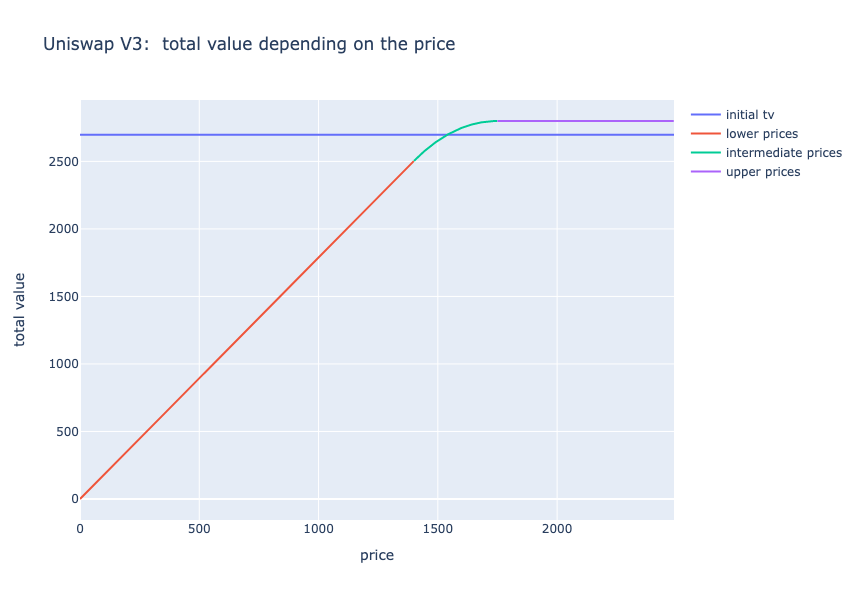

In [97]:
prices = np.array([price for price in range(0, 2500, 10)])
price0 = 1540
pa = 1400
pb = 1750
x0 = 1 # e.g. ethers

liquidity = get_liquidity_from_token0(x0, price0, pb)

lower_prices = np.array([price for price in range(0, pa)])

uniswap_v3_tvs_lower_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in lower_prices])

intermediate_prices = np.array([price for price in range(pa, pb)])

uniswap_v3_tvs_intermediate_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in intermediate_prices])

# calculating initial total value
initial_tvs = np.array([uniswap_v3_total_value(k=1, 
                                      L=liquidity, 
                                      p0=price0, 
                                      pa=pa, 
                                      pb=pb) for price in prices])

upper_prices = np.array([price for price in range(pb, max(prices))])

uniswap_v3_tvs_upper_prices = np.array([uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in upper_prices])

fig = go.Figure()
fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))
fig.add_trace(go.Scatter(x=lower_prices, y=uniswap_v3_tvs_lower_prices , name='lower prices'))
fig.add_trace(go.Scatter(x=intermediate_prices, y=uniswap_v3_tvs_intermediate_prices, name='intermediate prices'))
fig.add_trace(go.Scatter(x=upper_prices, y=uniswap_v3_tvs_upper_prices, name='upper prices'))

fig.update_layout(title='Uniswap V3:  total value depending on the price', xaxis_title='price', yaxis_title='total value', width=850, height=600)
fig.show()


Мы видим, что при падении цены базового актива суммарная стоимость позиции провайдера ликвидности будет тоже сильно падать.

Сейчас наш портфель состоит только из одной юнисвоп позиции.

#### Но что если мы добавим некоторое количество шорта?

То есть в нашем портфеле будет та же юнисвоп позиция, но плюс еще шорт, скажем, на $0.5$ эфира.

Тогда:

In [98]:
def short_pnl(short_amount, price0, price):
    return short_amount * (price0 - price)

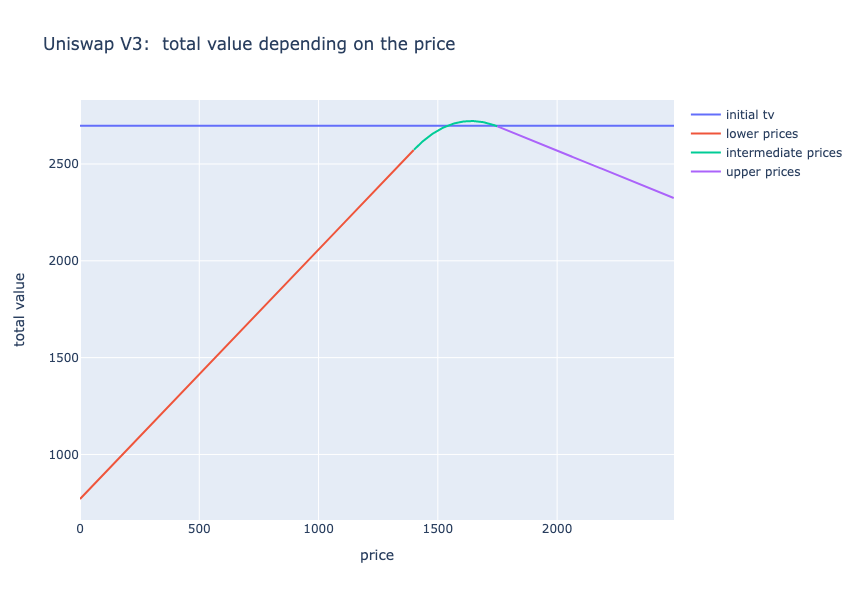

In [99]:
short_amount = 0.5 # eth


fig = go.Figure()
fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))
fig.add_trace(go.Scatter(x=lower_prices, y=short_pnl(short_amount, price0, lower_prices)+uniswap_v3_tvs_lower_prices , name='lower prices'))
fig.add_trace(go.Scatter(x=intermediate_prices, y=short_pnl(short_amount, price0, intermedate_prices)+uniswap_v3_tvs_intermediate_prices, name='intermediate prices'))
fig.add_trace(go.Scatter(x=upper_prices, y=short_pnl(short_amount, price0, upper_prices)+uniswap_v3_tvs_upper_prices, name='upper prices'))

fig.update_layout(title='Uniswap V3:  total value depending on the price', xaxis_title='price', yaxis_title='total value', width=850, height=600)
fig.show()

#### А что если выставить шорт в таком количестве, что профиль портфеля будет находиться ровно в вершине нашей псевдо-параболы?

Для этого мы и вводим дельту:

$$\Delta = \frac{\partial V}{\partial S}$$

Наша юнисвоп позиция - это функция $V(S)$. Посчитаем её дельту.

**Spoiler:** окажется, что наше текущее количество эфира - это и будет дельта.

Запишем суммарную стоимость позиции

$$V(S) = 2L\sqrt{S} - L(\sqrt{P_a} + \frac{S}{\sqrt{P_b}})$$

Берём производную:

$$\frac{\partial V}{\partial S} = L (\frac{1}{\sqrt{S}} - \frac{1}{\sqrt{P_b}} )$$


Теперь посчитаем применительно к нашей позиции:

$S_0 = \$1540$ <br>
$P_a = \$1400$ <br>
$P_b = \$1750$ <br>
$x_0 = 1$ ether

In [118]:
liquidity = get_liquidity_from_token0(x0, price0, pb)
delta = liquidity * (1 / (price0**0.5) - 1 / (pb**0.5))
print('delta:', delta)

delta: 1


То есть мы получили, что если мы будем держать в шорте 1 эфир, то мы будем находиться в вершине нашей псевдо-параболы:

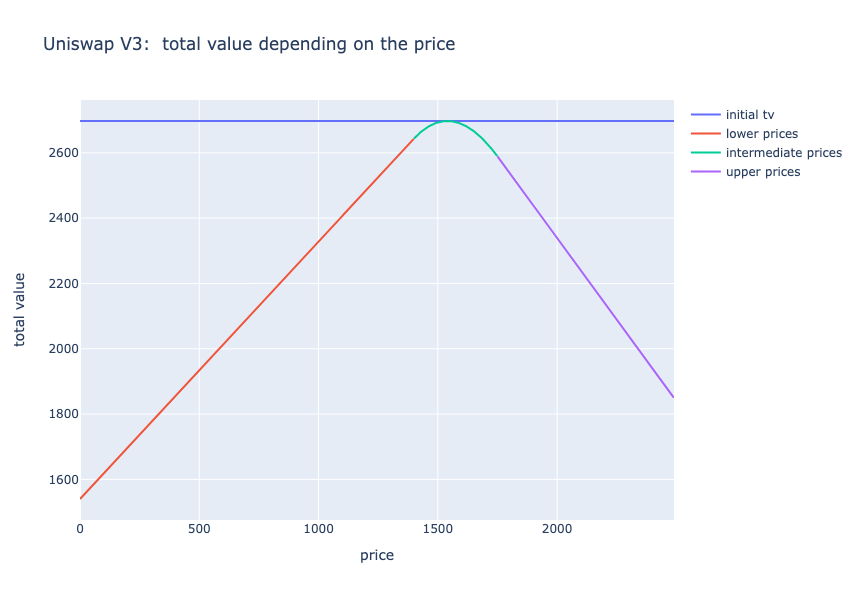

In [120]:
short_amount = 1 # eth


fig = go.Figure()
fig.add_trace(go.Scatter(x=prices, y=initial_tvs, mode='lines', name='initial tv'))
fig.add_trace(go.Scatter(x=lower_prices, y=short_pnl(short_amount, price0, lower_prices)+uniswap_v3_tvs_lower_prices , name='lower prices'))
fig.add_trace(go.Scatter(x=intermediate_prices, y=short_pnl(short_amount, price0, intermedate_prices)+uniswap_v3_tvs_intermediate_prices, name='intermediate prices'))
fig.add_trace(go.Scatter(x=upper_prices, y=short_pnl(short_amount, price0, upper_prices)+uniswap_v3_tvs_upper_prices, name='upper prices'))

fig.update_layout(title='Uniswap V3:  total value depending on the price', xaxis_title='price', yaxis_title='total value', width=850, height=600)
fig.show()


### В чём преимущества такой позиции?

Так как теперь мы находимся в вершине нашей псевдо-параболы, при небольших изменениях цены базового актива стоимость нашей позиции будет изменяться **очень слабо**.

Другими словами, мы **захеджировали первую частную производную**. Но, например, вторая частная производная (обычно её называют "гамма") всё еще открыта:

$$\gamma = \frac{\partial^2 V}{\partial S^2} \neq 0$$

Именно из-за неё мы захеджировались неидеально.

**Но мы всё ещё являемся провайдерами ликвидности на юнисвопе, соответственно зарабатываем комиссии.**

### Дельта-нейтральная стратегия

Нам выгодно находиться в вершине нашей псевдопараболы из-за нулевой дельты. Но цена изменяется, и мы смещаемся от вершины всё сильнее, и всё сильнее становимся зависимы от цены. Поэтому, если мы хотим всегда держаться около вершины, нам нужны **ребалансировки**.


#### Как часто ребалансировать?

Это подбирается эмпирически / через бектестинг. <br>
Например, можно выставить чтобы ребалансировка происходила при отклонении цены на $\Delta S = 1\%$.

#### Но в чём обратная сторона ребалансировки?

Когда мы делаем ребалансировку, мы из не-вершины попадаем в вершину новой параболы, соответственно наши непостоянные потери превращаются в постоянные. 

#### Тогда в чём смысл использовать ребалансировки?

Являясь провайдером ликвидности на юнисвопе, мы зарабатываем комиссии за каждую сделку. С одной стороны, при ребалансировках мы фиксируем наши потери, но с другой стороны, за время от прошлой ребалансировки до следующей ребалансировки мы заработали $\%$ комиссий. Соответственно заработок идёт тогда, когда заработанные комиссии больше чем impermanent loss, алгоритм приносит доход.

P.S. также при ребалансировках всегда есть ненулевые комиссии за транзакцию. Это тоже вносит свой вклад в частоту ребалансировок.
